# Kirkwood-Buff example: NaCl in water

In this example we calculate Kirkwood-Buff integrals in a solute (c) and solvent (w) system and correct for finite size effects as described at http://dx.doi.org/10.1073/pnas.0902904106 (see Supporting Information).

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import mdtraj as md
from math import pi
from scipy import integrate

### Load gromacs trajectory/topology

In [2]:
traj = md.load('gmx/traj_noh.xtc', top='gmx/conf_noh.gro')
print(traj)

<mdtraj.Trajectory with 50001 frames, 999 atoms, 999 residues, and unitcells>


### Calculate average number densities for solute and solvent

Average volume             =  29.6724630365 nm-3
Average side-length        =  3.09588295076 nm
Number of solute molecules =  36
Number of water molecules  =  963
Solute density             =  1.2132460981 nm-3
Water density              =  32.4543331241 nm-3


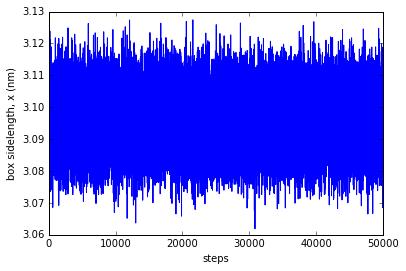

In [3]:
volume=0
for vec in traj.unitcell_lengths: 
  volume = volume + vec[0]*vec[1]*vec[2] / traj.n_frames
N_c   = len(traj.topology.select('name NA or name CL'))
N_w   = len(traj.topology.select('name O'))
rho_c = N_c / volume
rho_w = N_w / volume
print "Average volume             = ", volume, 'nm-3'
print "Average side-length        = ", volume**(1/3.), 'nm'
print "Number of solute molecules = ", N_c
print "Number of water molecules  = ", N_w
print "Solute density             = ", rho_c, 'nm-3'
print "Water density              = ", rho_w, 'nm-3'

steps=range(traj.n_frames)
plt.xlabel('steps')
plt.ylabel('box sidelength, x (nm)')
plt.plot(traj.unitcell_lengths[:,0])

### Compute and plot RDFs

CPU times: user 1.31 s, sys: 69.9 ms, total: 1.38 s
Wall time: 1.38 s
CPU times: user 37.2 s, sys: 2.77 s, total: 40 s
Wall time: 40 s


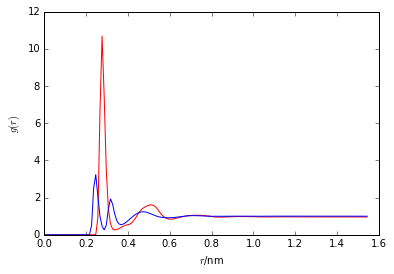

In [4]:
rmax = (volume)**(1/3.)/2
select_cc = traj.topology.select_pairs('name NA or name CL', 'name NA or name CL')
select_wc = traj.topology.select_pairs('name NA or name CL', 'name O')
%time r, g_cc = md.compute_rdf(traj, select_cc, r_range=[0.0,rmax], bin_width=0.01, periodic=True)
%time r, g_wc = md.compute_rdf(traj, select_wc, r_range=[0.0,rmax], bin_width=0.01, periodic=True)
g_cc = g_cc * len(select_cc) / (0.5*N_c**2) # re-scale to account for diagonal in pair matrix
plt.xlabel('$r$/nm')
plt.ylabel('$g(r)$')
plt.plot(r, g_cc, 'r-')
plt.plot(r, g_wc, 'b-')

### Calculate KB integrals
Here we calculate the number of solute molecules around other solute molecules (cc) and around water (wc).
For example,

$$ N_{cc} = 4\pi\rho_c\int_0^{\infty} \left ( g(r)_{cc} -1 \right ) r^2 dr$$

The peferential binding parameter is subsequesntly calculated as $\Gamma =  N_{cc}-N_{wc}$.

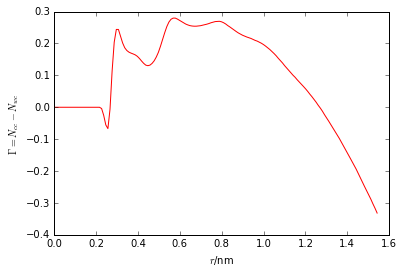

In [5]:
dr    = r[1]-r[0]
N_cc  = rho_c * 4*pi*np.cumsum( ( g_cc - 1 )*r**2*dr )
N_wc  = rho_c * 4*pi*np.cumsum( ( g_wc - 1 )*r**2*dr )
Gamma = N_cc - N_wc
plt.xlabel('$r$/nm')
plt.ylabel('$\\Gamma = N_{cc}-N_{wc}$')
plt.plot(r, Gamma, 'r-')

### Finite system size corrected KB integrals
In a finite sized $NVT$ simulation $g(r)$ can never exactly go to unity at large separations.
To correct for this a simple scaling factor can be applied,

$$ g_{gc}^{\prime} (r) = g_{jc}(r) \cdot
   \frac{N_j\left (1-V(r)/V\right )}{N_j\left (1-V(r)/V\right )-\Delta N_{jc}(r)-\delta_{jc}} $$

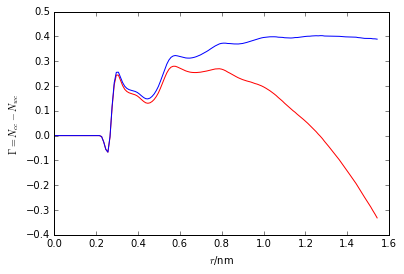

In [7]:
Vn = 4*pi/3*r**3 / volume
g_ccc = g_cc * N_c * (1-Vn) / ( N_c*(1-Vn)-N_cc-1)
g_wcc = g_wc * N_w * (1-Vn) / ( N_w*(1-Vn)-N_wc-0)

N_ccc  = rho_c * 4*pi*dr*np.cumsum( ( g_ccc - 1 )*r**2 )
N_wcc  = rho_c * 4*pi*dr*np.cumsum( ( g_wcc - 1 )*r**2 )
Gammac = N_ccc - N_wcc
plt.xlabel('$r$/nm')
plt.ylabel('$\\Gamma = N_{cc}-N_{wc}$')
plt.plot(r, Gamma, 'r-')
plt.plot(r, Gammac, 'b-')